# HDR
This document implements some of the HDR methods using opencv.
The pictures are loaded from the hdr directory (the intput directory path can be chnaged in code below)
The algorithm and the document are devided into the three parts:
* Initialization - load dependencies, load images and show imput images in figure. I also print the exposure values used for debvec and robertson algorithms.
* Mergin images - merge the image data set using all of the methods. In case of Merthems the exposures are not used.
* Apply tone mapping - applies one of the tone mapping on merge results (Drago, Durand, Reinhard or Mantiuk)

Implemented algorithms are Robertson, Debvec and Mertens. The result are shown in plots using several tone mapping methods.

## Results
I've got following results using code presented below:

![result](resources/result.png)

![input_data](resources/input_data.png)

## Initialization
As I mentioned following code tries to load dependencies, images from the hdr path and parse exposure constants. Exposure constant are parsed from the image file names using folowing pattern:
* "somestring...xxxxms...somestring" where xxxx is exposure in miliseconds, which will be parsed. So for [298]50kV-300uA-400ms 
the exposure will be 400 ms.

<IPython.core.display.Javascript object>


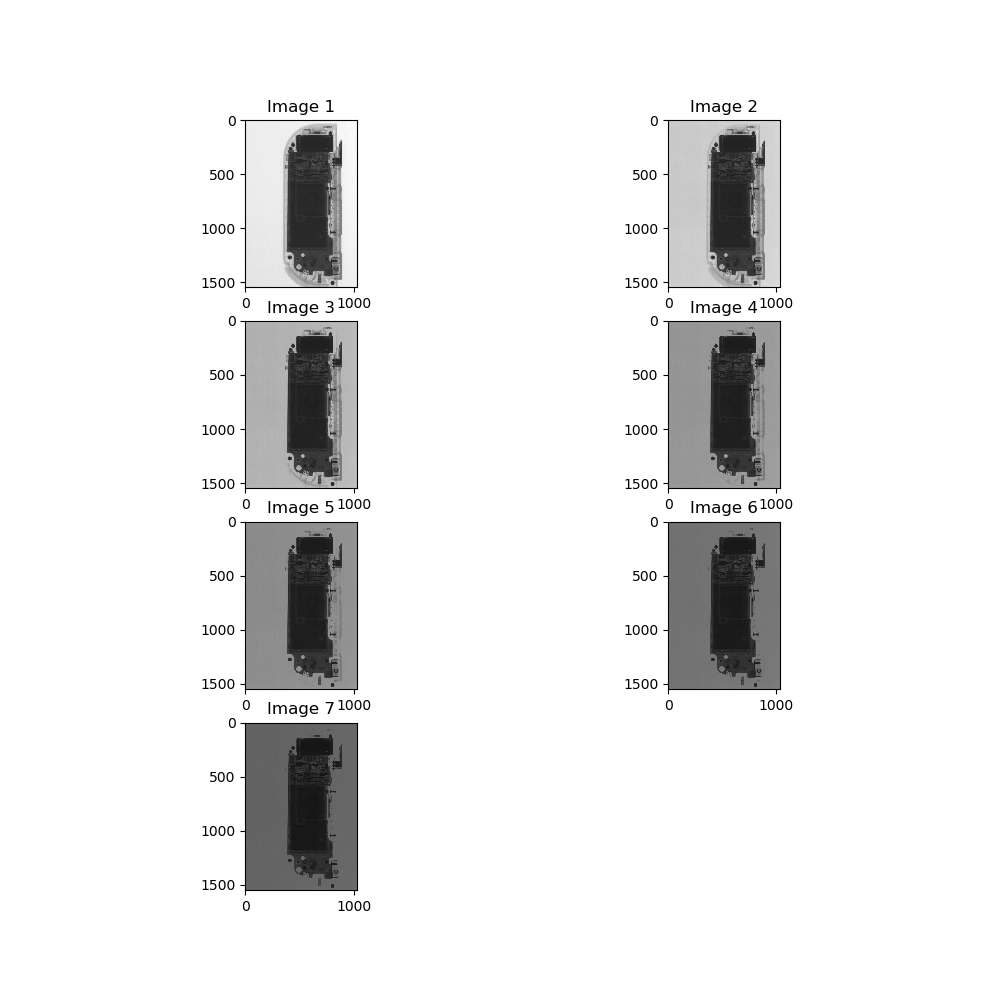

[ 0.40000001  0.5         0.60000002  0.69999999  0.80000001  0.89999998
  1.        ]


In [72]:
%matplotlib notebook

import glob
import random
import re

import matplotlib.pyplot as plt

from skimage import img_as_uint, img_as_ubyte, data
from skimage.io import imread, imsave

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets

import numpy as np

import cv2
images = []
exposures = []

# load images and its exposure
for filename in glob.glob('./hdr_images/*.tiff'):
    match = re.search('\d+(?=ms)', filename)
    images.append(cv2.imread(filename))
    exposures.append(int(match.group()) / 1000)
    
f, ax = plt.subplots(int(len(images) / 2) + 1, 2, figsize=(10, 10))

for idx, image in enumerate(images):
    ax[int(idx / 2), idx % 2].imshow(image)
    ax[int(idx / 2), idx % 2].set_title(f'Image {idx + 1}')

# hide last plot if is blank
if (idx + 1) % 2 == 1:
    ax[-1, -1].axis('off')

exposures = np.array(exposures, dtype=np.float32)
print(exposures)

## Merge exposure
Following code executes three mentioned methods. I had several problems with algorithms executions:
* exposures object have to be numpy array of type np.uint32
* images have to be numpy array of type np.uint8

In [45]:
merge_debvec = cv2.createMergeDebevec()
hdr_debvec = merge_debvec.process(images, times=exposures.copy())

merge_robertson = cv2.createMergeRobertson()
hdr_robertson = merge_robertson.process(images, times=exposures.copy())

merge_mertens = cv2.createMergeMertens()
res_mertens = merge_mertens.process(images)

## Apply tone mapping
Followinf code applies and plot results. Gamma can be adjusted using slider and refresh button.

Gamma:


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>


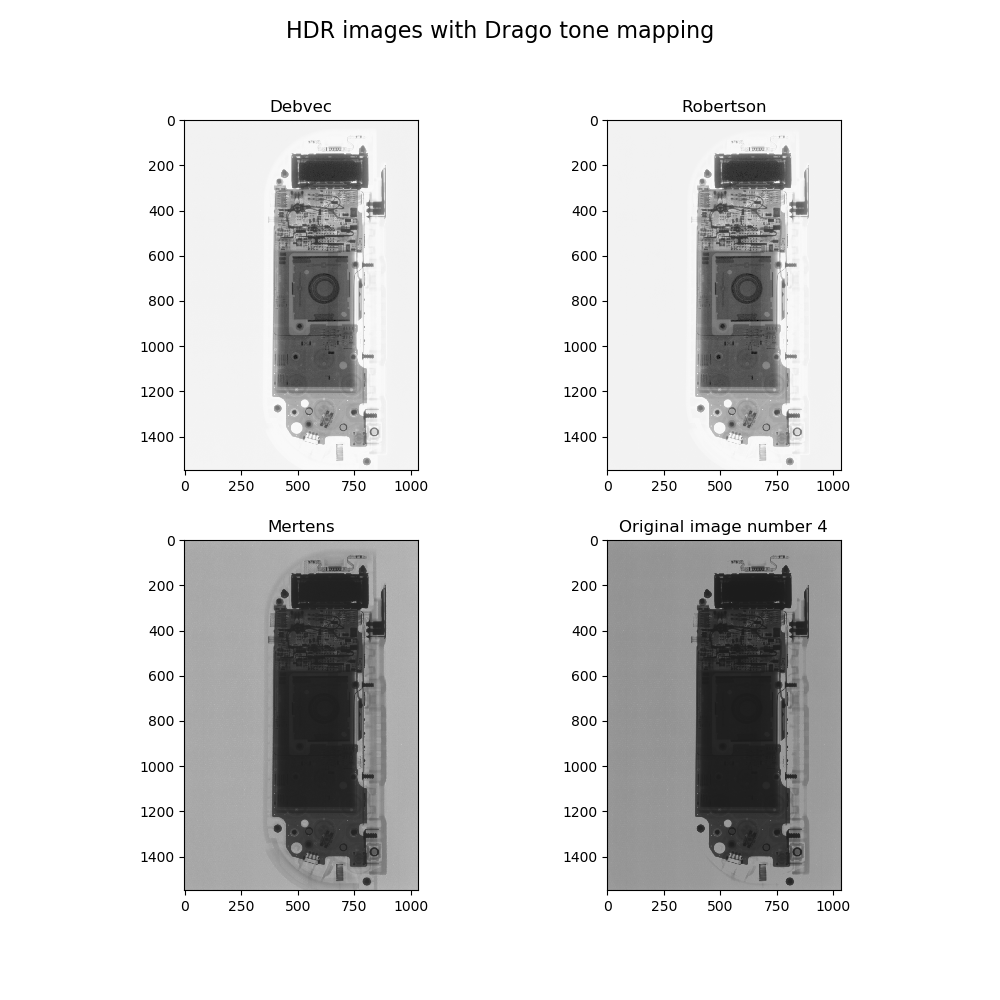

In [66]:
gamma = widgets.FloatSlider(min=-5, max=5, step=0.1, value=2.2, continuous_update=False)

refresh_button = widgets.Button(description='Refresh')
tone_mapping = widgets.RadioButtons(options=['Drago', 'Durand', 'Reinhard', 'Mantiuk'],
                                   value='Drago',
                                   description='Tone mapping:',
                                   disabled=False)

def on_button_clicked(b):
    # select tonemap
    if (tone_mapping.value == 'Drago'):
        tonemap = cv2.createTonemapDrago(gamma=gamma.value)
    elif (tone_mapping.value == 'Durand'):
        tonemap = cv2.createTonemapDurand(gamma=gamma.value)
    elif (tone_mapping.value == 'Reinhard'):
        tonemap = cv2.createTonemapReinhard(gamma=gamma.value)
    elif (tone_mapping.value == 'Mantiuk'):
        tonemap = cv2.createTonemapMantiuk(gamma=gamma.value)
    res_debvec = tonemap.process(hdr_debvec.copy())
    res_robertson = tonemap.process(hdr_robertson.copy())
    
    res_debvec_8bit = np.clip(res_debvec*255, 0, 255).astype('uint8')
    res_robertson_8bit = np.clip(res_robertson*255, 0, 255).astype('uint8')
    res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
    
    
    ax[0][0].imshow(res_debvec)
    ax[0][1].imshow(res_robertson)
    ax[1][0].imshow(res_mertens)
    f.suptitle(f'HDR images with {tone_mapping.value} tone mapping', fontsize=16)
    f.canvas.draw()
    
refresh_button.on_click(on_button_clicked)

print('Gamma:')
display(gamma)
display(tone_mapping)
display(refresh_button)
f, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].set_title('Debvec')
ax[0][1].set_title('Robertson')
ax[1][0].set_title('Mertens')

idx = int(len(images) / 2)
ax[1][1].set_title(f'Original image number {idx+1}')
ax[1][1].imshow(images[idx])

on_button_clicked(refresh_button)